Now we are going to use all the functions we defined in previous notebooks and set up a full data reduction workflow.

The steps are as follows
* Load and plot the data
* If **pointing offset observations have been done **
    * do bandpass correction 
    * measure the amplitude at the offset positions
    * calculate the pointing correction factor assuming a Gaussian beam
* Do bandpass correction on frequency-switched on-source pairs
* If more than one pair of observations have been done, repeat previous step on each pair
* Apply pointing correction factor to on-source spectra
* Apply point source sensitivity conversion factor for each polarisation.
    * **note that do do this, you need to go back to notebook 1, and find the drift scan closest in time to your selected spectral line observation, and calculate the PSS**
* Create an average spectrum for multiple observations for each polarisation
* Add together RCP and LCP to get total intensity
* Write the final spectrum to disk


In [1]:
from astropy.io import fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.time import Time
from scipy.optimize import curve_fit
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

def load_file(filename):
    """
    Open fits file, load spectra and extract information
    relevant to reductions.
    Returns a dictionary object.
    """
    hdulist = pyfits.open(filename)
    spectrum = {'Vlsr' : hdulist[2].data['Vlsr'],
                'LCP'  : hdulist[2].data['Polstate1'],
                'RCP'  : hdulist[2].data['Polstate4'],
                'units' : hdulist[2].header['TUNIT2'],
                'pointing' : hdulist[0].header['SPPOINT'],
                'position' : hdulist[2].header['POSITION'], 
                'HPBW' : hdulist[1].header['HPBW'],
                'date' : hdulist[0].header['DATE-OBS'],
                'object' : hdulist[0].header['OBJECT'],
                'longitude' : hdulist[0].header['LONGITUD'],
                'latitude' : hdulist[0].header['LATITUDE'],
                'equinox' : hdulist[0].header['EQUINOX'],
                'bw' : hdulist[0].header['SPBW'],
                'nchan' : hdulist[0].header['SPCHAN'],
                't_int' : hdulist[0].header['SPTIME'],
                'fs_offset' : hdulist[0].header['SPFS'],
                'spVlsr' : hdulist[0].header['SPVLSR'],
                'restfreq' : hdulist[0].header['RESTFREQ'],
                'centrefreq' : hdulist[2].header['CENTFREQ'], 
                'Tsys_lcp' : hdulist[3].header['TSYS1'],
                'DTsys_lcp' : hdulist[3].header['TSYSERR1'],
                'Tsys_rcp' : hdulist[3].header['TSYS2'],
                'DTsys_rcp': hdulist[3].header['TSYSERR2'] }
    return spectrum


In [3]:

def plot_spec(spec):
    """ Produce spectral plots given spectral line data"""
    plt.plot(spec['Vlsr'], spec['LCP'], label='LCP')
    plt.plot(spec['Vlsr'], spec['RCP'], label='RCP')
    plt.legend()
    plt.title(spec['object'] + ' ' + spec['date'])
    plt.xlabel('V_lsr (km/s)')
    plt.ylabel('Antenna temperature (K)')
    plt.axis('tight')

In [4]:

def freq_switch(spec1, spec2):
    """
    Correct for bandpass response using frequency-switching and
    return spectra over common velocity range.
    Inputs: 
    spec1 : first observation of frequency-switched pair
    spec2 : second observation of frequency-switched pair
    Returns:
    new_spec1: bandpass-corrected frequency range
    new_spec2: bandpass-corrected frequency range
    
    """
    #subtract reference spectrum from signal
    lcp1 = spec1['LCP'] - spec2['LCP']
    lcp2 = spec2['LCP'] - spec1['LCP']
    rcp1 = spec1['RCP'] - spec2['RCP']
    rcp2 = spec2['RCP'] - spec1['RCP']
    
    #find the indices of the common velocity channels for each spectrum
    spec1_common = np.nonzero(np.in1d(spec1['Vlsr'], spec2['Vlsr']))
    spec2_common = np.nonzero(np.in1d(spec2['Vlsr'], spec1['Vlsr']))
    
    #make a copy of the input spectra to preserve the header information
    new_spec1 = spec1.copy()
    new_spec2 = spec2.copy()
    
    #insert the new spectra into the copies
    new_spec1['Vlsr'] = spec1['Vlsr'][spec1_common]
    new_spec1['LCP'] = lcp1[spec1_common]
    new_spec1['RCP'] = rcp1[spec1_common]
    
    new_spec2['Vlsr'] = spec2['Vlsr'][spec2_common]
    new_spec2['LCP'] = lcp2[spec2_common]
    new_spec2['RCP'] = rcp2[spec2_common]

    
    return new_spec1, new_spec2

In [5]:

def flatten_baseline(Vlsr, Amp, line_range):
    """
    Remove residual baseline variation after frequency- or position-switching.
    Inputs:
        Vlsr: array of velocity values
        Amp: array of intensity as a function of velocity
        line_range: two-element array with start and end velocity of line emission.
        
    The line emmission range is masked before a fit is performed on the baseline.
    
    Returns: Corrected amplitude
    
    To do:  generalise mask to use multiple line ranges.
    """
    line_chans = np.where(np.logical_and(Vlsr>=line_range[0], Vlsr<=line_range[1]))
    mask = np.zeros(len(Amp))
    mask[line_chans] = 1
    vel_mask = np.ma.array(Vlsr, mask = mask)
    amp_mask = np.ma.array(Amp, mask = mask)

    #In general, we have found that a third-order polynomial is sufficient to fit the spectral baseline
    p = np.poly1d(np.ma.polyfit(vel_mask, amp_mask,  3))
    basefit = p(Vlsr)

    #plt.figure(figsize = [15,5])
    #plt.plot(Vlsr, Amp)
    #plt.plot(vel_mask, amp_mask)
    #plt.plot(Vlsr, basefit)
    #lim = plt.axis('tight')
    #plt.ylim(-2,5)
    #plt.ylabel('Amplitude')
    #plt.xlabel('Vlsr')

    Amp = Amp - basefit
    return Amp

In [6]:

# measure amplitude of peak for each pointing
def fit_max(spec, peak_vel, half_width, order):
    """
    Inputs:
        spec : a spectrum with columns 'Vlsr' and 'Amp'
        peak_vel : velocity at which to fit the maximum amplitdue
        half_width : How many channels to include on either side of the peak velocity.
                     This will depend on the width of the maser peak and 
                     how well a quadratic function fits the top of the peak
                     
    Returns:
        maximim amplitude
    """
    vel_chan = np.abs(spec['Vlsr']-peak_vel).argmin()

    #for noisy spectra - ie weak sources, it is better to do a quadratic fit over a few channels around the peak.
    chans = range(vel_chan-half_width, vel_chan+half_width)

    plt.plot(spec['Vlsr'][chans], spec['ave_pol'][chans], 'ko')
    p = np.poly1d(np.polyfit(spec['Vlsr'][chans], spec['ave_pol'][chans], order ))
    fit_x = np.linspace(spec['Vlsr'][min(chans)], spec['Vlsr'][max(chans)], 50)
    fit = p(fit_x)
    plt.plot(fit_x, fit, 'r')
    return  fit.max()

In [7]:
def gauss(x, *p):
    A, mu = p
    sigma = hpbw/(2*np.sqrt(2*np.log(2)))  #a bit messy but not sure how to pass a constant through the curve fitting
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def pointcor(north, south, east, west, cen, hpbw):
    """
    Given the power measured at the half-power points of the beam,
    calculate the correction factor for the source amplitude.
    The current implementation calculates the North-South and E-W 
    beams independently using a 1-D gaussian.
    We keep the width of the beam fixed during the fit.
    
    Inputs:
        north: Peak power measured at half-power point North 
        south: Peak power measured at half-power point South
        east: Peak power measured at half-power point East 
        west: Peak power measured at half-power point West
        cen: Peak power measured on source
        hpbw: half-power beam-width of the telescope
        
    Returns:
        Corrective factor for peak amplitude
    
    To do: 
        2D fit
        Uncertainty using T_sys
    """
    hhpbw = hpbw/2
    x = [-hhpbw, 0, +hhpbw]             
    p0 = [cen, 0.001]
    
    ns = [south, cen, north]
    ns_coeff, ns_var_matrix = curve_fit(gauss, x, ns, p0)
    smooth = np.linspace(-4*hhpbw, 4*hhpbw, 100)
    ns_fits = gauss(smooth, *ns_coeff)

    ew = [west, cen, east]
    ew_coeff, ew_var_matrix = curve_fit(gauss, x, ew, p0)
    ew_fits = gauss(smooth, *ew_coeff)

    fig = plt.figure(figsize=[8,3])
    ax = plt.subplot(121)
    plt.plot(x, ns, 'bo')
    plt.plot(smooth, ns_fits, color='b')
    plt.title('North-South pointing offset '+ str(round(ns_coeff[1],3)) +' deg')
    #plt.axis('tight')
    plt.vlines(ns_coeff[1]+hhpbw, 0, cen, linestyle='dotted')
    plt.vlines(ns_coeff[1], 0, cen, linestyle='dotted')
    plt.vlines(ns_coeff[1]-hhpbw, 0, cen, linestyle='dotted')
    ax = plt.subplot(122)
    plt.plot(x, ew, 'ro')
    plt.plot(smooth, ew_fits, color='r')
    #plt.axis('tight')
    plt.vlines(ew_coeff[1]+hhpbw, 0, cen, linestyle='dotted')
    plt.vlines(ew_coeff[1], 0, cen, linestyle='dotted')
    plt.vlines(ew_coeff[1]-hhpbw, 0, cen, linestyle='dotted')
    plt.title('East-West pointing offset '+str(round(ew_coeff[1],3)) +' deg')
    
    return np.exp(np.log(2) * (ns_coeff[1]**2 + ew_coeff[1]**2) / hhpbw**2)


In [8]:

def ave_pols(spec):
    """
    Average RCP and LCP pointing spectra and save in new data column.
    Return enhanced spectrum object.
    """
    spec['ave_pol'] = np.mean(np.vstack([spec['RCP'],spec['LCP']]), axis=0)
    return spec

In [9]:

def add_pols(spec):
    """
    Add RCP and LCP to get total intensity - Stokes I
    Return enhanced spectrum object.
    """
    spec['I'] = spec['RCP'] + spec['LCP']
    return spec

In [10]:

def calculate_pointing_corr(file_list):
    #Load half power point spectra
    hpn = load_file(file_list['filename'][np.where(file_list['position']=='HPN')][0])
    hps = load_file(file_list['filename'][np.where(file_list['position']=='HPS')][0])
    hpe = load_file(file_list['filename'][np.where(file_list['position']=='HPE')][0])
    hpw = load_file(file_list['filename'][np.where(file_list['position']=='HPW')][0])

    #find the frequency-switched pair that corresponds to the central pointing position
    on_point = np.where(np.logical_and(file_list['position']=='ON', file_list['pointing']==1))[0]
    on1 = load_file(file_list['filename'][on_point[0]])
    on2 = load_file(file_list['filename'][on_point[1]])

    #do frequency switch subtraction
    hpn_corr, hps_corr = freq_switch(hpn, hps)
    hpe_corr, hpw_corr = freq_switch(hpe, hpw)
    on1_corr, on2_corr = freq_switch(on1,on2)

    # Flatten baselines
    hpn_corr['LCP'] = flatten_baseline(hpn_corr['Vlsr'], hpn_corr['LCP'], line_range)
    hpn_corr['RCP'] = flatten_baseline(hpn_corr['Vlsr'], hpn_corr['RCP'], line_range)

    hps_corr['LCP'] = flatten_baseline(hps_corr['Vlsr'], hps_corr['LCP'], line_range)
    hps_corr['RCP'] = flatten_baseline(hps_corr['Vlsr'], hps_corr['RCP'], line_range)

    hpe_corr['LCP'] = flatten_baseline(hpe_corr['Vlsr'], hpe_corr['LCP'], line_range)
    hpe_corr['RCP'] = flatten_baseline(hpe_corr['Vlsr'], hpe_corr['RCP'], line_range)

    hpw_corr['LCP'] = flatten_baseline(hpw_corr['Vlsr'], hpw_corr['LCP'], line_range)
    hpw_corr['RCP'] = flatten_baseline(hpw_corr['Vlsr'], hpw_corr['RCP'], line_range)

    on1_corr['LCP'] = flatten_baseline(on1_corr['Vlsr'], on1_corr['LCP'], line_range)
    on1_corr['RCP'] = flatten_baseline(on1_corr['Vlsr'], on1_corr['RCP'], line_range)

    on2_corr['LCP'] = flatten_baseline(on2_corr['Vlsr'], on2_corr['LCP'], line_range)
    on2_corr['RCP'] = flatten_baseline(on2_corr['Vlsr'], on2_corr['RCP'], line_range)

    #average central spectra in time
    centre_point = ave_spec((on1_corr, on2_corr))

    #average polarisations to improve signal to noise ratio
    hpn_corr = ave_pols(hpn_corr)
    hps_corr = ave_pols(hps_corr)
    hpe_corr = ave_pols(hpe_corr)
    hpw_corr = ave_pols(hpw_corr)
    centre_point = ave_pols(centre_point)

    #Make a plot
    plt.figure(figsize=[10,10])
    plt.suptitle('Pointing observations for '+dirname)
    plt.subplot(332)
    plt.title('North')
    plt.plot(hpn_corr['Vlsr'], hpn_corr['ave_pol'])
    plt.subplot(334)
    plt.title('East')
    plt.plot(hpe_corr['Vlsr'], hpe_corr['ave_pol'])
    plt.subplot(335)
    plt.title('Centre')
    plt.plot(centre_point['Vlsr'], centre_point['ave_pol'])
    plt.subplot(336)
    plt.title('West')
    plt.plot(hpw_corr['Vlsr'], hpw_corr['ave_pol'])
    plt.subplot(338)
    plt.title('South')
    plt.plot(hps_corr['Vlsr'], hps_corr['ave_pol'])

    order = 4 #polynomial order for peak fit
    fig = plt.figure(figsize=[10,2])
    plt.suptitle('Peak fits for pointing observations on  '+dirname)
    plt.subplot(151)
    plt.title('North')
    north = fit_max(hpn_corr, peak_vel, half_width, order)
    plt.subplot(152)
    plt.title('South')
    south = fit_max(hps_corr, peak_vel, half_width, order)
    plt.subplot(153)
    plt.title('East')
    east = fit_max(hpe_corr, peak_vel, half_width, order)
    plt.subplot(154)
    plt.title('West')
    west = fit_max(hpw_corr, peak_vel, half_width, order)
    plt.subplot(155)
    plt.title('Centre')
    cen = fit_max(centre_point, peak_vel, half_width, order)
    fig.tight_layout()

    global hpbw #I really shouldn't do this - its because of the way I am doing the Gaussian fit.
    hpbw = centre_point['HPBW']
    pc = pointcor(north, south, east, west, cen, hpbw)
    print 'Pointing correction factor', pc
    return pc

In [11]:

def ave_spec(spectra):
    """
    Average a list of spectra in time using a weighting according to integration time.
    Return a new spectrum.
    """
    mjd_list = list()
    lcp_list = list()
    rcp_list = list()
    t_int_list = list()
    spec1 = spectra[1]
    for spec in spectra:
        mjd_list.append(Time(spec['date'], scale='utc', format='isot').mjd)
        lcp_list.append(spec['LCP'])
        rcp_list.append(spec['RCP'])
        t_int_list.append(spec['t_int'])
    mjd_list = np.array(mjd_list)
    lcp_list = np.array(lcp_list)
    rcp_list = np.array(rcp_list)
    t_int_list = np.array(t_int_list)
    ave_lcp = np.average(np.vstack(lcp_list),axis=0, weights=t_int_list)
    ave_rcp = np.average(np.vstack(rcp_list),axis=0, weights=t_int_list)
    mid_time = Time(np.mean(mjd_list), format='mjd').iso
    
    #construct new spectrum
    ave_spec = {'object' : spec1['object'],
                'longitude' : spec1['longitude'],
                'latitude' : spec1['latitude'],
                'equinox' : spec1['equinox'],
                't_int' : np.sum(t_int_list),
                'HPBW' : spec1['HPBW'],
                'date' : mid_time,    
                'Vlsr' : spec1['Vlsr'],
                'LCP' : ave_lcp,
                'RCP' : ave_rcp}
    return ave_spec

In [12]:
work_dir = '/Users/sharmila/AVN/Ghana_training/data/G0096_67/'

# Examine a test dataset first and determine the velocity range
# of the spectral line emission.
# Also know the velocity of the strongest peak
line_range = [-2.78, 7.22]
peak_vel = 1.2
half_width = 5   # number of channels on either side of the peak to use for peak fit

Processing 2004d003
Pointing correction factor 1.00839169301


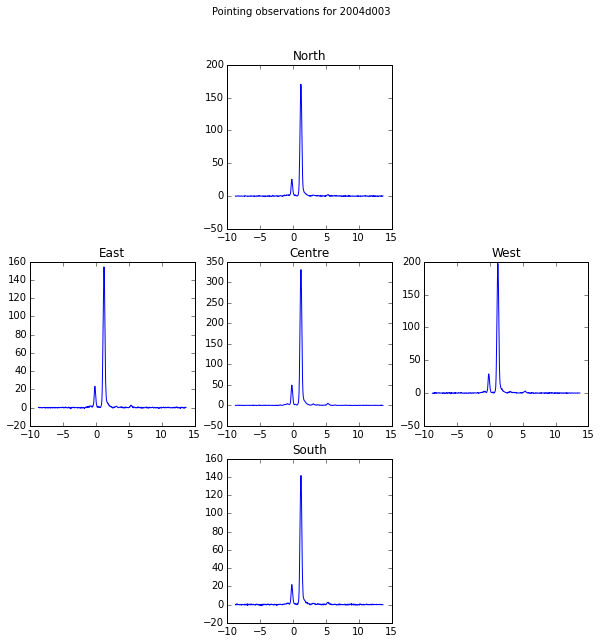

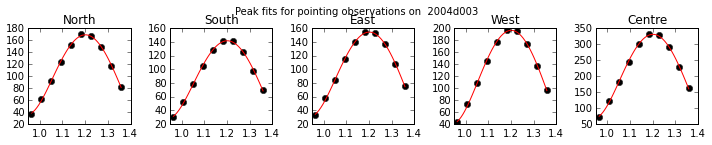

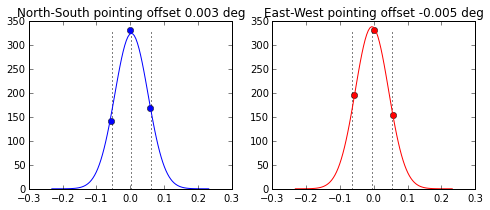

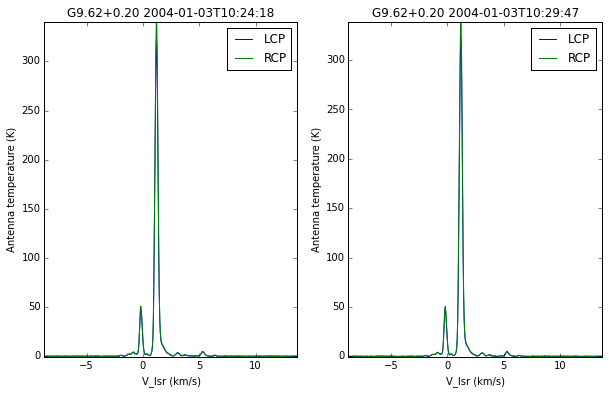

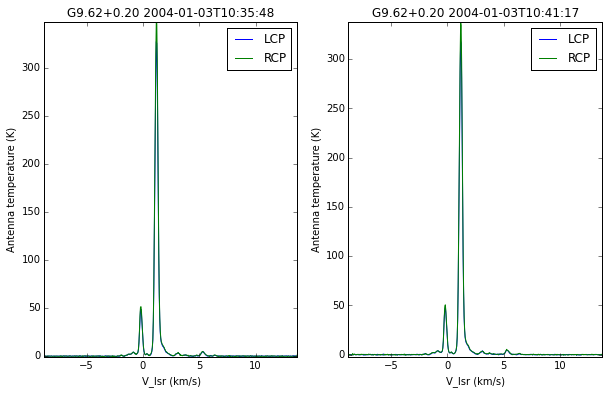

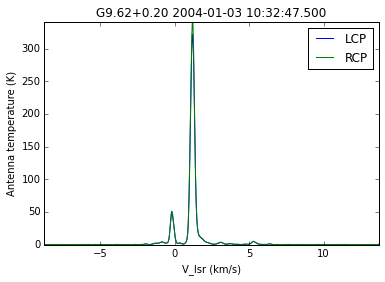

In [13]:
#iterate this block over a list of directories.
dirname = '2004d003'

os.chdir(work_dir+'/'+dirname)

print('Processing %s'%dirname)

#load filenames and scan identifiers
file_list = np.loadtxt(fname='list', delimiter=' ', 
                       dtype={'names' : ('filename', 'position', 'pointing'),
                             'formats' : ('S100', 'S3', 'b')})

#replace 'csv' extension with 'fits'
for i, filename in enumerate(file_list['filename']):
    file_list['filename'][i] = filename[0:-3] + 'fits'

num_pointing_obs = len((np.where(file_list['pointing']==1))[0])
if num_pointing_obs==6:
    pc = calculate_pointing_corr(file_list)
else:
    pc = 1
#get indices of the on-source files
full_int_on = np.where(np.logical_and(file_list['position']=='ON', file_list['pointing']==0))[0]
num_full_pairs = len(full_int_on)/2
#make an empty list to store the processed spectra
spectra = list()
for i in range(num_full_pairs):
    on_fs1 = load_file(file_list['filename'][full_int_on[i*2]])
    on_fs2 = load_file(file_list['filename'][full_int_on[i*2+1]])
    new_spec1, new_spec2 = freq_switch(on_fs1, on_fs2)
    #flatten baseline
    new_spec1['LCP'] = flatten_baseline(new_spec1['Vlsr'], new_spec1['LCP'], line_range)
    new_spec1['RCP'] = flatten_baseline(new_spec1['Vlsr'], new_spec1['RCP'], line_range)
    new_spec2['LCP'] = flatten_baseline(new_spec2['Vlsr'], new_spec2['LCP'], line_range)
    new_spec2['RCP'] = flatten_baseline(new_spec2['Vlsr'], new_spec2['RCP'], line_range)
    
    plt.figure(figsize=[10,6])
    plt.subplot(121)
    plot_spec(new_spec1)
    plt.subplot(122)
    plot_spec(new_spec2)
    spectra.append(new_spec1)
    spectra.append(new_spec2)
final_spec = ave_spec(spectra)
plt.figure()
plot_spec(final_spec)
#apply pointing correction
final_spec['LCP'] = final_spec['LCP']*pc
final_spec['RCP'] = final_spec['RCP']*pc
final_spec = add_pols(final_spec)

#Calculation of rms noise

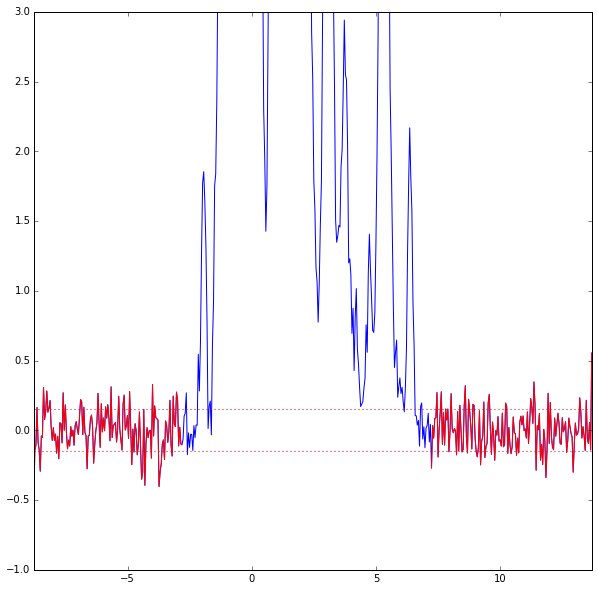

In [15]:
line_range = [-2.78, 7.22]
Amp = final_spec['I']
line_chans = np.where(np.logical_and(final_spec['Vlsr']>=line_range[0], final_spec['Vlsr']<=line_range[1]))
mask = np.zeros(len(Amp)) # initialise array filled with zeros
mask[line_chans] = 1
noise = np.ma.array(Amp, mask = mask)
rms = np.sqrt(np.ma.mean(noise**2))
plt.figure(figsize=[10,10])
ax = plt.subplot(111)
plt.plot(final_spec['Vlsr'], final_spec['I'])
plt.axis('tight')
plt.ylim(-1,3)
plt.plot(final_spec['Vlsr'], noise, color='r')
ax.axhline(-rms, color='r', linestyle=':')
ax.axhline(rms, color='r', linestyle=':')